# Data Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

# Project root in Drive
PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)

# Zip (already in Drive from data prep / T-A)
ZIP_PATH = PROJECT_ROOT / "asl-alphabet.zip"

print("Project root:", PROJECT_ROOT)
print("Zip exists:", ZIP_PATH.exists())

Mounted at /content/drive
Project root: /content/drive/MyDrive/Bharde_429_Final
Zip exists: True


In [3]:
import shutil, os, subprocess

# local unzip location (session-only)
LOCAL_BASE  = Path("/content/asl_alphabet_unzipped")
LOCAL_TRAIN = LOCAL_BASE / "asl_alphabet_train"
LOCAL_TEST  = LOCAL_BASE / "asl_alphabet_test"

LOCAL_BASE.mkdir(parents=True, exist_ok=True)

# if already unzipped in this session, reuse
if LOCAL_TRAIN.exists() and any(LOCAL_TRAIN.iterdir()):
    print("Using existing local unzipped data at:", LOCAL_TRAIN)
else:
    assert ZIP_PATH.exists(), "asl-alphabet.zip not found in PROJECT_ROOT."
    print("Unzipping from Drive zip -> /content ...")
    !unzip -q -o "{ZIP_PATH}" -d "{LOCAL_BASE}"

    # handle wrapper folder: /content/asl_alphabet_unzipped/asl_alphabet/
    wrapper = LOCAL_BASE / "asl_alphabet"
    if wrapper.exists():
        inner_train = wrapper / "asl_alphabet_train"
        inner_test  = wrapper / "asl_alphabet_test"
        if inner_train.exists():
            LOCAL_TRAIN.mkdir(exist_ok=True)
            for item in inner_train.iterdir():
                shutil.move(str(item), str(LOCAL_TRAIN))
        if inner_test.exists():
            LOCAL_TEST.mkdir(exist_ok=True)
            for item in inner_test.iterdir():
                shutil.move(str(item), str(LOCAL_TEST))
        shutil.rmtree(wrapper, ignore_errors=True)

    # handle double-nest: .../asl_alphabet_train/asl_alphabet_train/
    inner_train2 = LOCAL_TRAIN / "asl_alphabet_train"
    if inner_train2.exists():
        for item in inner_train2.iterdir():
            shutil.move(str(item), str(LOCAL_TRAIN))
        shutil.rmtree(inner_train2, ignore_errors=True)

    inner_test2 = LOCAL_TEST / "asl_alphabet_test"
    if inner_test2.exists():
        for item in inner_test2.iterdir():
            shutil.move(str(item), str(LOCAL_TEST))
        shutil.rmtree(inner_test2, ignore_errors=True)

print("Train root:", LOCAL_TRAIN)
print("Test root :", LOCAL_TEST)
!ls -l "{LOCAL_TRAIN}" | head

Unzipping from Drive zip -> /content ...
Train root: /content/asl_alphabet_unzipped/asl_alphabet_train
Test root : /content/asl_alphabet_unzipped/asl_alphabet_test
total 2288
drwxr-xr-x 2 root root  86016 Nov 14 17:25 A
drwxr-xr-x 2 root root  77824 Nov 14 17:25 B
drwxr-xr-x 2 root root  69632 Nov 14 17:25 C
drwxr-xr-x 2 root root  73728 Nov 14 17:25 D
drwxr-xr-x 2 root root  81920 Nov 14 17:25 del
drwxr-xr-x 2 root root  77824 Nov 14 17:25 E
drwxr-xr-x 2 root root  81920 Nov 14 17:25 F
drwxr-xr-x 2 root root  77824 Nov 14 17:25 G
drwxr-xr-x 2 root root  73728 Nov 14 17:25 H


In [5]:
from pathlib import Path
import pandas as pd

ACCEPT = {".jpg", ".jpeg", ".png"}

rows = []
for cdir in sorted([d for d in LOCAL_TRAIN.iterdir() if d.is_dir()]):
    label = cdir.name
    count = sum(1 for p in cdir.rglob("*") if p.is_file() and p.suffix.lower() in ACCEPT)
    rows.append((label, count))

counts = pd.DataFrame(rows, columns=["class", "count"]).sort_values("class")
print("Train classes found:", len(counts))
print("Train total images :", counts["count"].sum())
display(counts.head())

# test folder check (28 images total)
test_files = [p for p in LOCAL_TEST.iterdir() if p.is_file() and p.suffix.lower() in ACCEPT]
print("Test images in Kaggle test folder:", len(test_files))
[test_files[i].name for i in range(min(5, len(test_files)))]

Train classes found: 29
Train total images : 87000


,class,count
0,A,3000
1,B,3000
2,C,3000
3,D,3000
4,E,3000


Test images in Kaggle test folder: 28


['R_test.jpg', 'E_test.jpg', 'S_test.jpg', 'L_test.jpg', 'Z_test.jpg']

# Model Training

In [16]:
# === T-B: Fine-tune layer4 + head of ResNet-18 ===
import json, random, numpy as np, pandas as pd, contextlib
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, confusion_matrix

ART     = PROJECT_ROOT / "artifacts"
CKPT    = PROJECT_ROOT / "checkpoints"; CKPT.mkdir(exist_ok=True)
RESULTS = PROJECT_ROOT / "results";     RESULTS.mkdir(exist_ok=True)

SEED = 429
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
amp_ctx = torch.autocast(device_type="cuda", dtype=torch.float16) if USE_CUDA else contextlib.nullcontext()
if USE_CUDA:
    torch.backends.cudnn.benchmark = True
print("Device:", DEVICE)

# load artifacts
with open(ART / "class_to_idx.json") as f:
    class_to_idx = json.load(f)
classes = [c for c,_ in sorted(class_to_idx.items(), key=lambda kv: kv[1])]
NUM_CLASSES = len(classes)
print("NUM_CLASSES:", NUM_CLASSES, "Classes:", classes)

df_train = pd.read_csv(ART / "train_manifest.csv")
df_val   = pd.read_csv(ART / "val_manifest.csv")

print("Train rows:", len(df_train), "| Val rows:", len(df_val))
print(df_train.head(3))

Device: cuda
NUM_CLASSES: 27 Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'space']
Train rows: 64800 | Val rows: 16200
                                                path label   y
0  /content/asl_alphabet_unzipped/asl_alphabet_tr...     T  19
1  /content/asl_alphabet_unzipped/asl_alphabet_tr...     Y  24
2  /content/asl_alphabet_unzipped/asl_alphabet_tr...     U  20


In [17]:
# Transforms (ImageNet normalization)
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class ImageCSV(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df["path"].tolist()
        if "y" in df.columns:
            self.targets = df["y"].astype(int).tolist()
        else:
            self.targets = df["label"].map(class_to_idx).astype(int).tolist()
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.targets[idx]

train_ds = ImageCSV(df_train, tfm)
val_ds   = ImageCSV(df_val,   tfm)

BATCH_SIZE  = 64
NUM_WORKERS = 4

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2
)

print("Train batches:", len(train_loader), "| Val batches:", len(val_loader))

Train batches: 1013 | Val batches: 254


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [18]:
# ResNet-18: T-B configuration (layer4 + head trainable)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# replace final classifier head
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, NUM_CLASSES)

# freeze everything
for p in model.parameters():
    p.requires_grad = False

# unfreeze layer4 and head
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

# keep BN layers that are fully frozen in eval mode
def set_frozen_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        if all(not p.requires_grad for p in m.parameters()):
            m.eval()

model.apply(set_frozen_bn_eval)

model = model.to(DEVICE).to(memory_format=torch.channels_last)

criterion = nn.CrossEntropyLoss()
# smaller LR than T-A because we're tuning deeper layers
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-4)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / {total:,}")

Trainable params: 8,407,579 / 11,190,363


In [19]:
def _batch_correct(logits, y):
    preds = logits.argmax(1)
    return preds, (preds == y).sum().item()

@torch.no_grad()
def evaluate(model, loader, return_preds=False):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    all_pred, all_true = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE, memory_format=torch.channels_last)
        yb = torch.as_tensor(yb, device=DEVICE)
        with amp_ctx:
            logits = model(xb)
            loss = criterion(logits, yb)
        loss_sum += loss.item() * xb.size(0)
        preds, corr = _batch_correct(logits, yb)
        all_pred.extend(preds.cpu().tolist())
        all_true.extend(yb.cpu().tolist())
        correct += corr; total += xb.size(0)
    acc = correct / total
    f1  = f1_score(all_true, all_pred, average="macro")
    if return_preds:
        return loss_sum/total, acc, f1, (all_pred, all_true)
    return loss_sum/total, acc, f1

In [20]:
from copy import deepcopy

EPOCHS = 5
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}

best_f1   = -1.0
best_state = None
patience, bad = 1, 0

for epoch in range(1, EPOCHS+1):
    model.train()
    tr_tot, tr_corr, tr_loss_sum = 0, 0, 0.0

    for xb, yb in train_loader:
        xb = xb.to(DEVICE, memory_format=torch.channels_last)
        yb = torch.as_tensor(yb, device=DEVICE)

        optimizer.zero_grad(set_to_none=True)
        with amp_ctx:
            logits = model(xb)
            loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        tr_loss_sum += loss.item() * xb.size(0)
        preds, corr = _batch_correct(logits, yb)
        tr_corr += corr; tr_tot += xb.size(0)

    tr_loss = tr_loss_sum / tr_tot
    tr_acc  = tr_corr / tr_tot

    va_loss, va_acc, va_f1 = evaluate(model, val_loader)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)
    history["val_f1"].append(va_f1)

    tag = ""
    if va_f1 > best_f1:
        best_f1   = va_f1
        best_state = deepcopy(model.state_dict())
        bad = 0
        tag = "<= BEST"
    else:
        bad += 1

    print(f"Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | "
          f"val {va_loss:.4f}/{va_acc:.3f} F1 {va_f1:.4f} {tag}")

    if bad > patience:
        print("Early stopping (macro-F1 plateau).")
        break

best_path = CKPT / "best_TB.pt"
torch.save(best_state, best_path)
print("Saved best checkpoint:", best_path, "| Best val macro-F1:", f"{best_f1:.4f}")

Epoch 01 | train 0.1368/0.978 | val 0.0060/0.999 F1 0.9993 <= BEST
Epoch 02 | train 0.0022/1.000 | val 0.0013/1.000 F1 0.9999 <= BEST
Epoch 03 | train 0.0008/1.000 | val 0.0028/0.999 F1 0.9993 
Epoch 04 | train 0.0061/0.999 | val 0.0008/1.000 F1 0.9999 <= BEST
Epoch 05 | train 0.0003/1.000 | val 0.0007/1.000 F1 0.9999 
Saved best checkpoint: /content/drive/MyDrive/Bharde_429_Final/checkpoints/best_TB.pt | Best val macro-F1: 0.9999


In [21]:
import numpy as np

# curves
pd.DataFrame(history).to_csv(RESULTS / "TB_history.csv", index=False)

print("Saved:", RESULTS / "TB_history.csv")

Saved: /content/drive/MyDrive/Bharde_429_Final/results/TB_history.csv


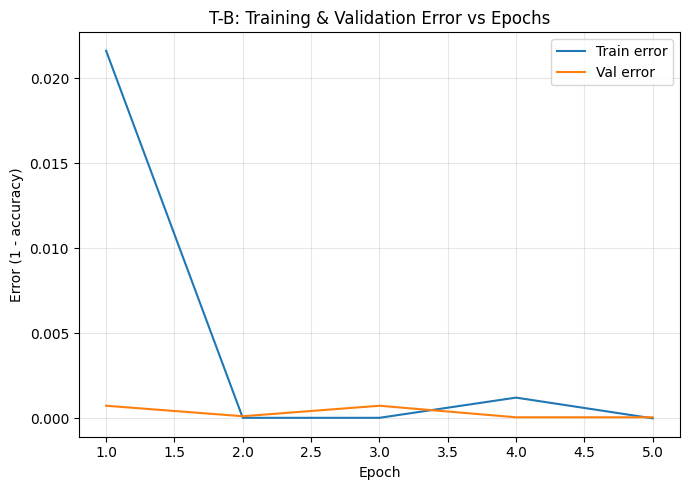

In [22]:
import matplotlib.pyplot as plt

hist_TB = pd.read_csv(RESULTS / "TB_history.csv")
epochs  = range(1, len(hist_TB)+1)

plt.figure(figsize=(7,5))
plt.plot(epochs, 1 - hist_TB["train_acc"], label="Train error")
plt.plot(epochs, 1 - hist_TB["val_acc"],   label="Val error")
plt.xlabel("Epoch"); plt.ylabel("Error (1 - accuracy)")
plt.title("T-B: Training & Validation Error vs Epochs")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(RESULTS / "TB_error_curves.png", dpi=200)
plt.show()

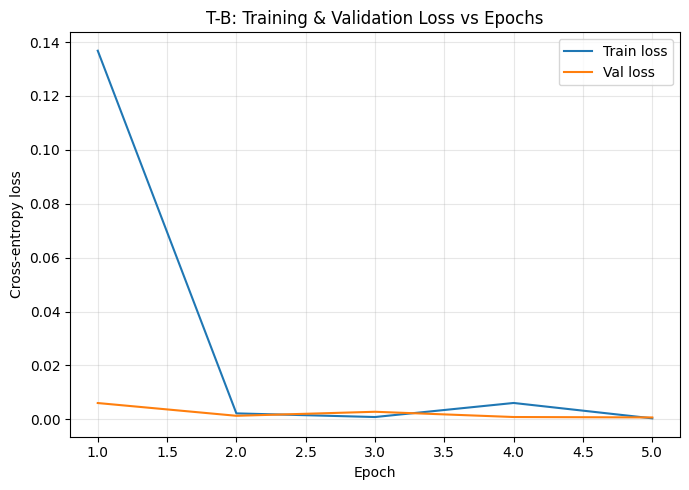

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# load history (already saved after training)
hist_TB = pd.read_csv(RESULTS / "TB_history.csv")
epochs  = range(1, len(hist_TB) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, hist_TB["train_loss"], label="Train loss")
plt.plot(epochs, hist_TB["val_loss"],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("T-B: Training & Validation Loss vs Epochs")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS / "TB_loss_curves.png", dpi=200)
plt.show()

# Model Testing

In [24]:
# rebuild same architecture and load best_TB.pt for testing
model_test = models.resnet18(weights=None)
model_test.fc = nn.Linear(model_test.fc.in_features, NUM_CLASSES)
model_test.load_state_dict(torch.load(CKPT / "best_TB.pt", map_location=DEVICE))
model_test = model_test.to(DEVICE).eval()

idx_to_class = {v:k for k,v in class_to_idx.items()}

from typing import List, Tuple

def list_images_flat(root: Path):
    exts = {".jpg",".jpeg",".png"}
    return [p for p in sorted(root.iterdir()) if p.is_file() and p.suffix.lower() in exts]

def list_images_by_subfolders(root: Path) -> List[Tuple[Path,str]]:
    exts = {".jpg",".jpeg",".png"}
    items = []
    for d in sorted([x for x in root.iterdir() if x.is_dir()]):
        label = d.name
        for p in d.rglob("*"):
            if p.is_file() and p.suffix.lower() in exts:
                items.append((p, label))
    return items

@torch.no_grad()
def predict_paths(paths: List[Path]) -> List[int]:
    preds = []
    for p in paths:
        img = Image.open(p).convert("RGB")
        x = tfm(img).unsqueeze(0).to(DEVICE)
        logits = model_test(x)
        preds.append(int(logits.argmax(1).item()))
    return preds

def evaluate_folder(folder: Path, mode: str = "auto", save_tag: str = "TB"):
    folder = Path(folder)
    assert folder.exists(), f"Folder not found: {folder}"

    if mode == "auto":
        mode = "subfolders" if any(x.is_dir() for x in folder.iterdir()) else "flat"

    paths, true_labels = [], []

    if mode == "subfolders":
        items = list_images_by_subfolders(folder)
        if len(items) == 0:
            raise RuntimeError("No images found under subfolders.")
        for p, lbl in items:
            if lbl not in class_to_idx:
                continue
            paths.append(p)
            true_labels.append(class_to_idx[lbl])
    else:
        files = list_images_flat(folder)
        if len(files) == 0:
            raise RuntimeError("No images found in flat folder.")
        for p in files:
            base = p.name
            # e.g., "A_test_1.jpg" -> "A"
            letter = base.split("_")[0][0].upper()
            lbl = letter
            # optionally handle 'space' explicitly if you use it
            if base.lower().startswith("space_"):
                lbl = "space"
            if lbl not in class_to_idx:
                continue
            paths.append(p)
            true_labels.append(class_to_idx[lbl])

    pred_idx = predict_paths(paths)
    acc = f1_score(true_labels, pred_idx, average="micro")  # micro-F1 == accuracy
    f1  = f1_score(true_labels, pred_idx, average="macro")
    cm  = confusion_matrix(true_labels, pred_idx, labels=list(range(NUM_CLASSES)))

    out_csv = RESULTS / f"{save_tag}_predictions.csv"
    pd.DataFrame({
        "path": [str(p) for p in paths],
        "y_true": true_labels,
        "y_pred": pred_idx,
        "true_label": [idx_to_class[i] for i in true_labels],
        "pred_label": [idx_to_class[i] for i in pred_idx],
    }).to_csv(out_csv, index=False)
    out_npy = RESULTS / f"{save_tag}_cm.npy"
    np.save(out_npy, cm)

    print(f"[{save_tag}] files: {len(paths)} | acc: {acc:.4f} | macro-F1: {f1:.4f}")
    print("Saved:", out_csv.name, "and", out_npy.name)
    return acc, f1, cm

In [25]:
KAGGLE_TEST_DIR = LOCAL_TEST
MY_TEST_DIR     = Path("/content/drive/MyDrive/Bharde_429_Final/new_asl_alphabet_test")

acc_kagg_TB, f1_kagg_TB, cm_kagg_TB = evaluate_folder(
    KAGGLE_TEST_DIR, mode="flat", save_tag="TB_kaggle28"
)

acc_cust_TB, f1_cust_TB, cm_cust_TB = evaluate_folder(
    MY_TEST_DIR, mode="flat", save_tag="TB_custom"
)

print("\nT-B Kaggle 28  -> acc =", f"{acc_kagg_TB:.4f}", ", macro-F1 =", f"{f1_kagg_TB:.4f}")
print("T-B Custom 20 -> acc =", f"{acc_cust_TB:.4f}", ", macro-F1 =", f"{f1_cust_TB:.4f}")

[TB_kaggle28] files: 28 | acc: 0.9643 | macro-F1: 0.9753
Saved: TB_kaggle28_predictions.csv and TB_kaggle28_cm.npy
[TB_custom] files: 20 | acc: 0.1000 | macro-F1: 0.0595
Saved: TB_custom_predictions.csv and TB_custom_cm.npy

T-B Kaggle 28  -> acc = 0.9643 , macro-F1 = 0.9753
T-B Custom 20 -> acc = 0.1000 , macro-F1 = 0.0595
